# XGBRanker .predict() Functionality Test

This notebook tests the XGBoost .predict() functionality with:
1. Dummy dataset for training, validation, and testing
2. Early stopping on validation set
3. Precision@5 calculation using torchmetrics
4. Retraining with best iteration
5. Verification of .predict() iteration behavior

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torchmetrics
from torchmetrics.retrieval import RetrievalPrecision
import warnings
warnings.filterwarnings("ignore")

print(f"XGBoost version: {xgb.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchmetrics version: {torchmetrics.__version__}")

XGBoost version: 2.1.3
PyTorch version: 2.0.1
Torchmetrics version: 1.8.0



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/kianyewngieng/.local/share/uv/python/cpython-3.10.17-macos-aarch64-none/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/kianyewngieng/.local/share/uv/python/cpython-3.10.17-macos-aarch64-none/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/kianyewngieng/github_projects/practice_sequential_data/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_ins

## Step 1: Create Dummy Dataset for XGBRanker

In [2]:
# Create dummy ranking dataset
def create_ranking_dataset(n_queries=1000, n_features=20, items_per_query_range=(10, 50)):
    """
    Create a dummy ranking dataset suitable for XGBRanker
    
    Args:
        n_queries: Number of query groups
        n_features: Number of features per item
        items_per_query_range: Range of items per query (min, max)
    
    Returns:
        X: Feature matrix
        y: Relevance scores (0-4 scale)
        groups: Group sizes for each query
        query_ids: Query identifiers for each item
    """
    X_list = []
    y_list = []
    groups = []
    query_ids = []
    
    np.random.seed(42)  # For reproducibility
    
    for query_id in range(n_queries):
        # Random number of items per query
        n_items = np.random.randint(items_per_query_range[0], items_per_query_range[1] + 1)
        
        # Generate features for this query's items
        X_query, _ = make_classification(
            n_samples=n_items,
            n_features=n_features,
            n_informative=n_features//2,
            n_redundant=0,
            n_clusters_per_class=1,
            random_state=42 + query_id
        )
        
        # Generate relevance scores (0-4 scale, with some bias towards higher scores)
        # Higher feature values tend to have higher relevance
        feature_sum = np.sum(X_query, axis=1)
        percentiles = np.percentile(feature_sum, [20, 40, 60, 80])
        
        y_query = np.zeros(n_items)
        for i, score in enumerate(feature_sum):
            if score <= percentiles[0]:
                y_query[i] = 0
            elif score <= percentiles[1]:
                y_query[i] = 1
            elif score <= percentiles[2]:
                y_query[i] = 2
            elif score <= percentiles[3]:
                y_query[i] = 3
            else:
                y_query[i] = 4
        
        # Add some noise to make it more realistic
        noise = np.random.randint(-1, 2, n_items)
        y_query = np.clip(y_query + noise, 0, 4)
        
        X_list.append(X_query)
        y_list.append(y_query)
        groups.append(n_items)
        query_ids.extend([query_id] * n_items)
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    return X, y, groups, np.array(query_ids)

# Create the dataset
print("Creating dummy ranking dataset...")
X_full, y_full, groups_full, query_ids_full = create_ranking_dataset(
    n_queries=1000, n_features=20, items_per_query_range=(10, 30)
)

print(f"Dataset created:")
print(f"  Total items: {len(X_full)}")
print(f"  Features: {X_full.shape[1]}")
print(f"  Queries: {len(groups_full)}")
print(f"  Relevance score distribution: {np.bincount(y_full.astype(int))}")

Creating dummy ranking dataset...
Dataset created:
  Total items: 19909
  Features: 20
  Queries: 1000
  Relevance score distribution: [4228 3946 3811 3880 4044]


In [3]:
# Split dataset into train, validation, and test sets by queries
def split_ranking_dataset(X, y, groups, query_ids, train_ratio=0.6, val_ratio=0.2):
    """
    Split ranking dataset by queries to maintain query integrity
    """
    unique_queries = np.unique(query_ids)
    n_queries = len(unique_queries)
    
    # Split queries
    train_queries, temp_queries = train_test_split(
        unique_queries, train_size=train_ratio, random_state=42
    )
    val_queries, test_queries = train_test_split(
        temp_queries, train_size=val_ratio/(1-train_ratio), random_state=42
    )
    
    # Create masks for each split
    train_mask = np.isin(query_ids, train_queries)
    val_mask = np.isin(query_ids, val_queries)
    test_mask = np.isin(query_ids, test_queries)
    
    # Split data
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    # Calculate groups for each split
    train_groups = [groups[i] for i, q in enumerate(unique_queries) if q in train_queries]
    val_groups = [groups[i] for i, q in enumerate(unique_queries) if q in val_queries]
    test_groups = [groups[i] for i, q in enumerate(unique_queries) if q in test_queries]
    
    # Get query IDs for each split
    train_query_ids = query_ids[train_mask]
    val_query_ids = query_ids[val_mask]
    test_query_ids = query_ids[test_mask]
    
    return (
        (X_train, y_train, train_groups, train_query_ids),
        (X_val, y_val, val_groups, val_query_ids),
        (X_test, y_test, test_groups, test_query_ids)
    )

# Split the dataset
print("Splitting dataset into train/validation/test...")
train_data, val_data, test_data = split_ranking_dataset(X_full, y_full, groups_full, query_ids_full)

X_train, y_train, train_groups, train_query_ids = train_data
X_val, y_val, val_groups, val_query_ids = val_data
X_test, y_test, test_groups, test_query_ids = test_data

print(f"Train set: {len(X_train)} items, {len(train_groups)} queries")
print(f"Validation set: {len(X_val)} items, {len(val_groups)} queries")
print(f"Test set: {len(X_test)} items, {len(test_groups)} queries")

Splitting dataset into train/validation/test...
Train set: 11913 items, 600 queries
Validation set: 3940 items, 200 queries
Test set: 4056 items, 200 queries


## Step 2: Train XGBRanker with Early Stopping

In [4]:
# Initialize XGBRanker with early stopping
print("Training XGBRanker with early stopping...")

# Create XGBRanker model
model = xgb.XGBRanker(
    objective='rank:pairwise',
    n_estimators=500,  # Large number for early stopping
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='ndcg@5'  # Use NDCG@5 for evaluation
)

# Train with early stopping on validation set
model.fit(
    X_train, y_train,
    group=train_groups,
    eval_set=[(X_val, y_val)],
    eval_group=[val_groups],
    verbose=100  # Print every 100 rounds
)

print(f"\nTraining completed!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score}")
print(f"Total estimators trained: {model.n_estimators}")

Training XGBRanker with early stopping...
[0]	validation_0-ndcg@5:0.53541
[100]	validation_0-ndcg@5:0.83046
[196]	validation_0-ndcg@5:0.84620

Training completed!
Best iteration: 146
Best score: 0.8487693090721313
Total estimators trained: 500


## Step 3: Test .predict() and Calculate Precision@5

In [6]:
# Function to calculate Precision@5 using torchmetrics
def calculate_precision_at_k(y_true, y_pred, query_ids, k=5):
    """
    Calculate Precision@K using torchmetrics RetrievalPrecision
    
    Args:
        y_true: True relevance scores
        y_pred: Predicted scores
        query_ids: Query identifiers
        k: Number of top items to consider
    
    Returns:
        precision_at_k: Average precision@k across all queries
    """
    # Convert to torch tensors
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    query_ids_tensor = torch.tensor(query_ids, dtype=torch.long)
    
    # Create binary relevance (relevant if score >= 3)
    binary_relevance = (y_true_tensor >= 3).float()
    
    # Initialize RetrievalPrecision metric
    precision_metric = RetrievalPrecision(top_k=k)
    
    # Calculate precision@k
    precision_at_k = precision_metric(y_pred_tensor, binary_relevance, indexes=query_ids_tensor)
    
    return precision_at_k.item()

# Test the model using .predict() (uses all trained estimators by default)
print("Testing model with .predict() (all estimators)...")
test_predictions_all = model.predict(X_test)

# Calculate Precision@5
precision_at_5_all = calculate_precision_at_k(
    y_test, test_predictions_all, test_query_ids, k=5
)

print(f"Precision@5 (all estimators): {precision_at_5_all:.4f}")
print(f"Number of estimators used: {model.n_estimators}")

Testing model with .predict() (all estimators)...
Precision@5 (all estimators): 0.8700
Number of estimators used: 500


## Step 4: Retrain with Best Iteration and Test Again

In [7]:
# Retrain the model using only the best iteration count
print(f"\nRetraining model with best iteration count: {model.best_iteration + 1}...")

# Create new model with n_estimators set to best_iteration + 1
model_best = xgb.XGBRanker(
    objective='rank:pairwise',
    n_estimators=model.best_iteration + 1,  # Use best iteration count
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='ndcg@5'
)

# Train without early stopping (since we know the optimal number of estimators)
model_best.fit(
    X_train, y_train,
    group=train_groups,
    verbose=False  # Silent training
)

print(f"Retraining completed with {model_best.n_estimators} estimators.")

# Test the retrained model
print("Testing retrained model with .predict()...")
test_predictions_best = model_best.predict(X_test)

# Calculate Precision@5 for retrained model
precision_at_5_best = calculate_precision_at_k(
    y_test, test_predictions_best, test_query_ids, k=5
)

print(f"Precision@5 (retrained with best iteration): {precision_at_5_best:.4f}")


Retraining model with best iteration count: 147...
Retraining completed with 147 estimators.
Testing retrained model with .predict()...
Precision@5 (retrained with best iteration): 0.8700


## Step 5: Test .predict() with Specific Iteration Range

In [ ]:
# Test whether .predict() uses n_iterations=(0, model.best_iteration+1)
print("\nTesting .predict() with specific iteration ranges...")

# Test predict with iteration_range parameter
# Note: XGBoost predict method supports iteration_range parameter

# 1. Predict using only the first few estimators
early_iterations = min(50, model.best_iteration)
test_predictions_early = model.predict(X_test, iteration_range=(0, early_iterations))
precision_at_5_early = calculate_precision_at_k(
    y_test, test_predictions_early, test_query_ids, k=5
)

print(f"Precision@5 (first {early_iterations} estimators): {precision_at_5_early:.4f}")

# 2. Predict using estimators up to best_iteration
test_predictions_best_range = model.predict(X_test, iteration_range=(0, model.best_iteration + 1))
precision_at_5_best_range = calculate_precision_at_k(
    y_test, test_predictions_best_range, test_query_ids, k=5
)

print(f"Precision@5 (0 to best_iteration+1={model.best_iteration + 1}): {precision_at_5_best_range:.4f}")

# 3. Compare predictions from retrained model vs original model with iteration_range
print("\nComparing predictions:")
print(f"Retrained model (best iteration only): {precision_at_5_best:.4f}")
print(f"Original model (0 to best_iteration+1): {precision_at_5_best_range:.4f}")
print(f"Original model (all estimators): {precision_at_5_all:.4f}")

# Check if predictions are identical
predictions_match = np.allclose(test_predictions_best, test_predictions_best_range, rtol=1e-10)
print(f"\nDo predictions match between retrained and iteration_range? {predictions_match}")

if predictions_match:
    print("✅ VERIFIED: .predict() with iteration_range=(0, best_iteration+1) produces identical results to retraining with best_iteration estimators")
else:
    print("❌ WARNING: Predictions differ between retrained model and iteration_range usage")
    # Show the difference
    max_diff = np.max(np.abs(test_predictions_best - test_predictions_best_range))
    print(f"Maximum absolute difference: {max_diff}")

## Summary and Analysis

In [ ]:
# Summary of results
print("\n" + "="*60)
print("SUMMARY OF XGBOOST .predict() FUNCTIONALITY TEST")
print("="*60)

print(f"\n📊 Dataset Statistics:")
print(f"  • Total queries: {len(groups_full)}")
print(f"  • Total items: {len(X_full)}")
print(f"  • Features per item: {X_full.shape[1]}")
print(f"  • Train/Val/Test split: {len(train_groups)}/{len(val_groups)}/{len(test_groups)} queries")

print(f"\n🏋️ Training Results:")
print(f"  • Total estimators configured: {model.n_estimators}")
print(f"  • Best iteration (early stopping): {model.best_iteration}")
print(f"  • Best validation score: {model.best_score:.4f}")

print(f"\n🎯 Precision@5 Results:")
print(f"  • All estimators: {precision_at_5_all:.4f}")
print(f"  • First {early_iterations} estimators: {precision_at_5_early:.4f}")
print(f"  • Best iteration range (0, {model.best_iteration + 1}): {precision_at_5_best_range:.4f}")
print(f"  • Retrained with best iteration: {precision_at_5_best:.4f}")

print(f"\n🔍 Key Findings:")
print(f"  • Early stopping improved performance: {precision_at_5_best_range > precision_at_5_early}")
print(f"  • Best iteration vs all estimators: {precision_at_5_best_range:.4f} vs {precision_at_5_all:.4f}")
print(f"  • Predictions match between methods: {predictions_match}")

if precision_at_5_best_range > precision_at_5_all:
    print(f"  ✅ Early stopping prevented overfitting (best < all)")
elif precision_at_5_best_range < precision_at_5_all:
    print(f"  ⚠️  All estimators performed better (possible underfitting)")
else:
    print(f"  ➡️  Performance identical (early stopping at optimal point)")

print(f"\n💡 Conclusion:")
if predictions_match:
    print(f"  The .predict() method with iteration_range=(0, best_iteration+1)")
    print(f"  produces identical results to retraining with the optimal number")
    print(f"  of estimators, confirming that XGBoost correctly implements")
    print(f"  partial prediction functionality.")
else:
    print(f"  There are differences between the two approaches, which may")
    print(f"  indicate implementation details or numerical precision issues.")

print("\n" + "="*60)

In [12]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Create a synthetic dataset for regression
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train an XGBoost model with early stopping
xgb_model = XGBRegressor(n_estimators=1000, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
# Evaluate the final model on the test set
score = xgb_model.score(X_test, y_test)
print(f"Early Stopping Test R^2 score: {score:.4f}")

# Retrieve the best iteration number
best_iteration = xgb_model.best_iteration

# Train a new model with the best iteration number
final_model = XGBRegressor(n_estimators=best_iteration)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
score = final_model.score(X_test, y_test)
print(f"Best iteration: {best_iteration}, Test R^2 score: {score:.4f}")

Early Stopping Test R^2 score: 0.8350
Best iteration: 45, Test R^2 score: 0.8349


In [5]:
import shap

In [14]:
df = pd.DataFrame(X_test).copy()
df['query_id'] = test_query_ids
final_model = model
X = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
y = pd.DataFrame(y_test)
# Initialize SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for all instances
shap_values = explainer.shap_values(X)

# Select specific instances (e.g., first instance of each query_id)
instances_to_explain = df.groupby('query_id').first().index
selected_instances = df[df['query_id'].isin(instances_to_explain)].index[:3]  # First 3 instances

# Print local SHAP values for selected instances
print("\nLocal SHAP Values for Selected Instances:")
for idx in selected_instances:
    print(f"\nInstance {idx} (query_id: {df.loc[idx, 'query_id']}):")
    print(f"Features: {X.loc[idx].to_dict()}")
    print(f"Relevance: {y.loc[idx]}")
    print(f"SHAP Values: {shap_values[idx]}")
    print(f"Base value: {explainer.expected_value}")
    print(f"Sum of SHAP values + base: {explainer.expected_value + sum(shap_values[idx])}")

# Visualize SHAP values for the first selected instance
# shap.initjs()  # Initialize JavaScript visualization for SHAP
# shap.force_plot(explainer.expected_value, shap_values[selected_instances[0]], X.iloc[selected_instances[0]], matplotlib=True)


Local SHAP Values for Selected Instances:

Instance 0 (query_id: 0):
Features: {'feature_0': -2.2994632087736955, 'feature_1': -1.1013222573083006, 'feature_2': -1.434088869232524, 'feature_3': 0.5145889906905393, 'feature_4': -0.10194951247985722, 'feature_5': 2.0728862837644346, 'feature_6': 0.6418285404089622, 'feature_7': 0.05747400302429677, 'feature_8': -1.0460884453976451, 'feature_9': -0.5590254932338569, 'feature_10': 0.10678535215097473, 'feature_11': -0.6246002099858479, 'feature_12': -0.3055762009742241, 'feature_13': 0.04213408174192956, 'feature_14': -0.8154990732884886, 'feature_15': -0.19153282391329285, 'feature_16': -1.8458595299210696, 'feature_17': -2.282802490040798, 'feature_18': 1.2046350725758252, 'feature_19': 1.7512402288834001}
Relevance: 0    0.0
Name: 0, dtype: float64
SHAP Values: [-0.2532812  -0.11619123 -0.11961745  0.06499543 -0.00624533  0.2561401
  0.04272082  0.0228893  -0.1183451  -0.03891603 -0.01146642 -0.06633404
 -0.03179003  0.04694286 -0.0642

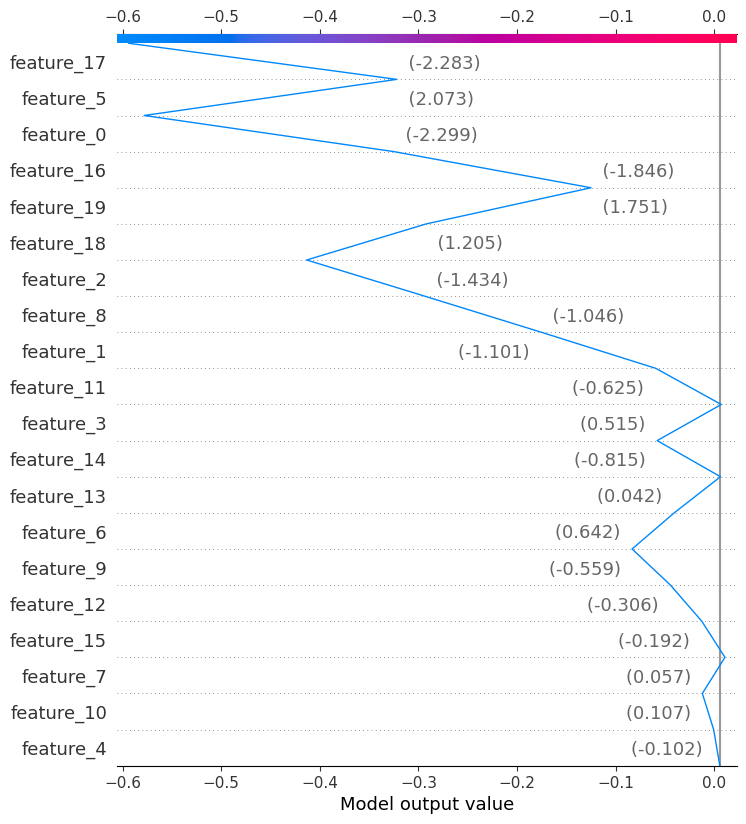

In [15]:
# Visualize SHAP values for the first selected instance
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values[selected_instances[0]], X.iloc[selected_instances[0]])

# Shap Value for Instances

In [16]:
instances_to_explain = df[df['query_id']==0]
instances_to_explain['prediction'] = final_model.predict(instances_to_explain.iloc[:,:-1])
idx = 0
print(f"SHAP Values: {shap_values[idx]}")
print(f"Sum of SHAP values + base: {explainer.expected_value + sum(shap_values[idx])}")
print(f'Prediction: {instances_to_explain.iloc[idx, -1]}')

SHAP Values: [-0.2532812  -0.11619123 -0.11961745  0.06499543 -0.00624533  0.2561401
  0.04272082  0.0228893  -0.1183451  -0.03891603 -0.01146642 -0.06633404
 -0.03179003  0.04694286 -0.06422031 -0.02344167 -0.19985558 -0.27180555
  0.12140948  0.1670027 ]
Sum of SHAP values + base: -0.5937827825546265
Prediction: -0.5937828421592712


In [ ]:
local_feature_importance = {feat:val.item() for feat, val in zip(X.columns, shap_values[idx])}
dict(sorted(local_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True))

In [29]:
def instance_idx_to_explain(instances_to_explain, idx):
    print(f"SHAP Values: {shap_values[idx]}")
    print(f"Sum of SHAP values + base: {explainer.expected_value + sum(shap_values[idx])}")
    print(f'Prediction: {instances_to_explain.iloc[idx, -1]}')
    
    local_feature_importance = {feat:val.item() for feat, val in zip(X.columns, shap_values[idx])}
    feature_ranking = dict(sorted(local_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True))
    print(f"Feature Ranking: {feature_ranking}")
    return feature_ranking
instance_idx_to_explain(instances_to_explain, 14)


SHAP Values: [ 0.15328622  0.37624142 -0.04481897  0.09081454 -0.10222942 -0.00650313
  0.263702    0.08002165  0.23675668  0.20641494  0.05178703  0.21496165
 -0.06578597 -0.00457877  0.03030583  0.12457632 -0.3337898   0.03017154
  0.04374614 -0.15027085]
Sum of SHAP values + base: 1.2004356384277344
Prediction: -0.906190037727356
Feature Ranking: {'feature_1': 0.37624141573905945, 'feature_16': -0.33378979563713074, 'feature_6': 0.26370200514793396, 'feature_8': 0.23675668239593506, 'feature_11': 0.21496164798736572, 'feature_9': 0.20641493797302246, 'feature_0': 0.15328621864318848, 'feature_19': -0.15027084946632385, 'feature_15': 0.12457631528377533, 'feature_4': -0.10222941637039185, 'feature_3': 0.09081453830003738, 'feature_7': 0.08002164959907532, 'feature_12': -0.0657859668135643, 'feature_10': 0.05178702995181084, 'feature_2': -0.04481897130608559, 'feature_18': 0.043746136128902435, 'feature_14': 0.030305827036499977, 'feature_17': 0.03017153963446617, 'feature_5': -0.0065

{'feature_1': 0.37624141573905945,
 'feature_16': -0.33378979563713074,
 'feature_6': 0.26370200514793396,
 'feature_8': 0.23675668239593506,
 'feature_11': 0.21496164798736572,
 'feature_9': 0.20641493797302246,
 'feature_0': 0.15328621864318848,
 'feature_19': -0.15027084946632385,
 'feature_15': 0.12457631528377533,
 'feature_4': -0.10222941637039185,
 'feature_3': 0.09081453830003738,
 'feature_7': 0.08002164959907532,
 'feature_12': -0.0657859668135643,
 'feature_10': 0.05178702995181084,
 'feature_2': -0.04481897130608559,
 'feature_18': 0.043746136128902435,
 'feature_14': 0.030305827036499977,
 'feature_17': 0.03017153963446617,
 'feature_5': -0.006503129843622446,
 'feature_13': -0.004578768741339445}

In [26]:
instances_to_explain.sort_values(by='prediction', ascending=False, inplace=True)
instances_to_explain

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,query_id,prediction
1,2.465319,-3.299896,0.700243,0.340922,0.295478,2.225784,-1.038031,-0.073611,1.820136,1.476659,...,5.570931,-1.097346,0.741963,-0.132299,4.045523,-0.282221,-0.086414,1.386476,0,1.340452
14,1.379247,4.208333,0.169973,1.489045,-1.020383,0.027764,2.143298,1.026580,2.153133,1.551263,...,-0.373088,-0.269094,0.114861,1.153245,-1.963077,0.166088,0.877825,-1.280234,0,1.200435
5,-0.983421,0.985399,-1.101252,-0.446683,2.055093,-0.171471,-0.624775,0.747368,3.008022,-0.075304,...,-1.744737,-0.319360,-0.122911,0.487673,1.863487,-0.290692,-0.475671,1.801440,0,0.920118
3,0.725528,-0.562598,-1.792045,-0.699147,0.770678,1.519078,-0.642157,1.204923,1.736094,1.065227,...,2.857919,0.667056,1.912318,-0.446774,-0.948230,-1.196660,-0.008817,0.084330,0,0.635536
10,-2.903000,-2.323217,0.492686,0.069653,-0.343201,5.873978,-0.224576,-1.445610,-2.185220,0.770863,...,1.412041,0.457676,1.271138,0.088873,4.213450,-0.844137,0.983504,-1.535923,0,0.588060
2,-2.273399,1.962149,-1.730873,-0.486714,0.200134,2.726798,-0.156317,0.886064,-0.016152,-0.342309,...,-0.455792,-2.170866,-0.433650,1.444339,-1.255090,-0.137078,1.334446,1.022445,0,0.171265
11,0.618718,-1.736214,-0.157724,0.571348,-1.912707,2.954170,-2.666751,1.032600,0.637902,0.784006,...,-0.529437,0.362476,-1.452849,-1.355058,1.895146,-1.810131,0.970524,0.360653,0,-0.051978
13,-2.180665,1.865855,-1.368590,0.242334,-0.827893,1.384456,-0.875592,1.060447,1.943550,-1.599123,...,-0.500430,-0.303864,-0.313024,0.535492,-2.444053,1.541371,2.047399,1.193999,0,-0.083734
7,0.464099,-0.702796,0.028621,-0.810506,1.523787,-0.999288,3.096651,-0.972269,1.833168,-0.987936,...,-3.991262,-2.456747,0.851402,0.968623,1.114006,0.079482,-0.904542,0.694023,0,-0.178045
4,-0.687649,0.164393,-0.014718,1.122678,-0.006199,0.195380,2.804906,-0.281385,0.560667,0.330701,...,-2.319355,0.403119,0.981547,0.796405,-1.662854,-1.664693,-1.441196,1.296537,0,-0.225785


In [ ]:
local_feature_importance = {feat:val.item() for feat, val in zip(X.columns, shap_values[idx])}
dict(sorted(local_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True))

# Partial Dependence Plot

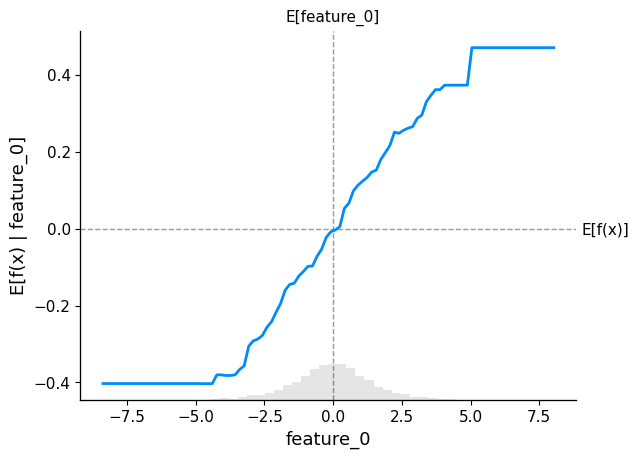

In [31]:
shap.partial_dependence_plot(
    "feature_0",
    model.predict,
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

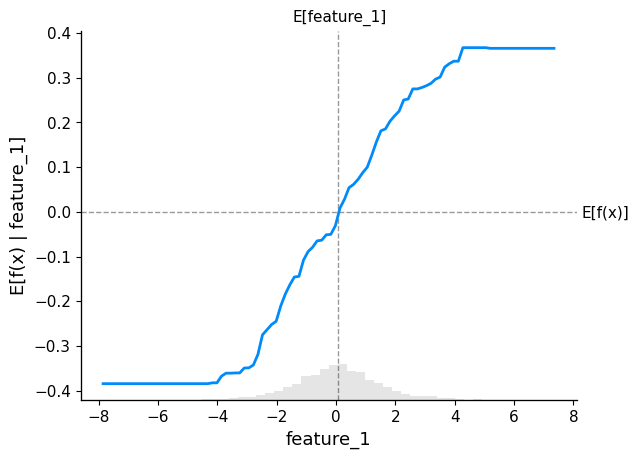

In [34]:
shap.partial_dependence_plot(
    "feature_1",
    model.predict,
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)